In [1]:
import tensorflow as tf
from tensorflow.examples.tutorials.mnist import input_data
import numpy as np
import time
import os
import tflearn
from utils import *
os.environ["CUDA_VISIBLE_DEVICES"]='1'


In [2]:
mnist_data = input_data.read_data_sets("MNIST_data", one_hot=True)

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


# Residual Network

In [3]:
inputs = tf.placeholder(tf.float32, [None, 28, 28, 1], name='inputs')
targets = tf.placeholder(tf.float32, [None, 2], name='targets')
input_shortcut = tf.placeholder(tf.float32, [None, 2], name='input_shortcut')
train_flag = tf.placeholder(tf.bool, name='training')


net = tflearn.conv_2d(inputs, 64, 3, activation='relu', bias=False)
# Residual blocks
net = tflearn.residual_bottleneck(net, 3, 16, 64)
net = tflearn.residual_bottleneck(net, 1, 32, 128, downsample=True)
net = tflearn.residual_bottleneck(net, 2, 32, 128)
net = tflearn.residual_bottleneck(net, 1, 64, 256, downsample=True)
net = tflearn.residual_bottleneck(net, 2, 64, 256)
net = tflearn.batch_normalization(net)
net = tflearn.activation(net, 'relu')
net = tflearn.global_avg_pool(net)

net = tflearn.fully_connected(net, 200, activation='relu')
feature_transform = tflearn.fully_connected(net, 2, activation='relu')
output = dense_custom(tf.cond(train_flag, lambda: feature_transform,
                              lambda: input_shortcut),
                      2, 2, activation=None)

#This part is for computing the accuracy of this model
pred_y = tf.nn.softmax(output)
pred_y_true = tf.argmax(pred_y, 1)
y_true = tf.argmax(targets, 1)
correct_prediction = tf.equal(pred_y_true, y_true)
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

# loss function and optimizer
cost = tf.reduce_mean((tf.nn.softmax_cross_entropy_with_logits(logits=output, labels=targets)))
optimizer = tf.train.AdamOptimizer(0.0001).minimize(cost)
# optimizer = tf.train.MomentumOptimizer(0.0001, 0.9).minimize(cost)
saver = tf.train.Saver(tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES))

In [4]:
config = tf.ConfigProto()
config.log_device_placement=False
config.allow_soft_placement=True
config.gpu_options.allow_growth=True
session = tf.Session(config=config)
session.run(tf.global_variables_initializer())

# Training helper functions

In [5]:
def get_2_class(imgs, labs):
    label = np.argmax(labs,1)
    index_0 = np.where(label==0)[0]
    index_1 = np.where(label==1)[0]
    index = list(index_0)+list(index_1)
    images = imgs[index]
    label = label[index]
    label = to_categorical(label, 2)
    return images, label

In [6]:
batch_size = 4096
def optmizer(epochs):

    for i in (range(epochs)):
        epoch_loss = []
        start_epoch = time.time()
        for ii in range(mnist_data.train.num_examples//batch_size):
            batch = mnist_data.train.next_batch(batch_size)
            imgs = batch[0].reshape((-1, 28, 28, 1))
            labs = batch[1]
            imgs, labs = get_2_class(imgs, labs)

            dict_input = {inputs:imgs, targets:labs, train_flag: True, 
                         input_shortcut: np.zeros([batch_size, 2])}

            c, _ = session.run([cost, optimizer], feed_dict=dict_input)
            epoch_loss.append(c)
        print("Epoche: {}/{}".format(i+1, epochs), "| Training accuracy: ", session.run(accuracy, feed_dict=dict_input), 
              "| Cost: {}".format(np.mean(epoch_loss)), " | Time for epoch: {:.2f}s".format(time.time() - start_epoch))
        if i%100==0:
            saver.save(session,'../model/mnist_resnet_{}.ckpt'.format(i))

# Train and check

In [7]:
optmizer(1000)

('Epoche: 1/1000', '| Training accuracy: ', 0.48441243, '| Cost: 0.676861703396', ' | Time for epoch: 10.78s')
('Epoche: 2/1000', '| Training accuracy: ', 0.46875, '| Cost: 0.632158875465', ' | Time for epoch: 9.62s')
('Epoche: 3/1000', '| Training accuracy: ', 0.45838085, '| Cost: 0.563115954399', ' | Time for epoch: 9.19s')
('Epoche: 4/1000', '| Training accuracy: ', 0.9847596, '| Cost: 0.429897516966', ' | Time for epoch: 9.26s')
('Epoche: 5/1000', '| Training accuracy: ', 0.9917839, '| Cost: 0.393047779799', ' | Time for epoch: 9.17s')
('Epoche: 6/1000', '| Training accuracy: ', 0.98943657, '| Cost: 0.381394386292', ' | Time for epoch: 9.20s')
('Epoche: 7/1000', '| Training accuracy: ', 0.9897959, '| Cost: 0.379549920559', ' | Time for epoch: 9.20s')
('Epoche: 8/1000', '| Training accuracy: ', 0.9953051, '| Cost: 0.371042400599', ' | Time for epoch: 8.84s')
('Epoche: 9/1000', '| Training accuracy: ', 0.9964328, '| Cost: 0.367955207825', ' | Time for epoch: 9.38s')
('Epoche: 10/1000

('Epoche: 77/1000', '| Training accuracy: ', 0.99886495, '| Cost: 0.31743362546', ' | Time for epoch: 9.32s')
('Epoche: 78/1000', '| Training accuracy: ', 1.0, '| Cost: 0.316620230675', ' | Time for epoch: 9.32s')
('Epoche: 79/1000', '| Training accuracy: ', 1.0, '| Cost: 0.3157376647', ' | Time for epoch: 9.32s')
('Epoche: 80/1000', '| Training accuracy: ', 1.0, '| Cost: 0.315378129482', ' | Time for epoch: 10.12s')
('Epoche: 81/1000', '| Training accuracy: ', 0.99999994, '| Cost: 0.314517050982', ' | Time for epoch: 10.82s')
('Epoche: 82/1000', '| Training accuracy: ', 0.9999999, '| Cost: 0.315345138311', ' | Time for epoch: 10.11s')
('Epoche: 83/1000', '| Training accuracy: ', 0.9999999, '| Cost: 0.313499301672', ' | Time for epoch: 8.36s')
('Epoche: 84/1000', '| Training accuracy: ', 0.9988611, '| Cost: 0.313259541988', ' | Time for epoch: 8.36s')
('Epoche: 85/1000', '| Training accuracy: ', 1.0, '| Cost: 0.312479227781', ' | Time for epoch: 8.43s')
('Epoche: 86/1000', '| Training 

('Epoche: 153/1000', '| Training accuracy: ', 0.9999999, '| Cost: 0.274509906769', ' | Time for epoch: 8.72s')
('Epoche: 154/1000', '| Training accuracy: ', 0.9988317, '| Cost: 0.274057179689', ' | Time for epoch: 8.80s')
('Epoche: 155/1000', '| Training accuracy: ', 1.0, '| Cost: 0.274017959833', ' | Time for epoch: 8.70s')
('Epoche: 156/1000', '| Training accuracy: ', 0.99999994, '| Cost: 0.272728383541', ' | Time for epoch: 8.74s')
('Epoche: 157/1000', '| Training accuracy: ', 1.0, '| Cost: 0.272724419832', ' | Time for epoch: 8.89s')
('Epoche: 158/1000', '| Training accuracy: ', 1.0000001, '| Cost: 0.272010236979', ' | Time for epoch: 8.83s')
('Epoche: 159/1000', '| Training accuracy: ', 1.0, '| Cost: 0.272472679615', ' | Time for epoch: 8.67s')
('Epoche: 160/1000', '| Training accuracy: ', 0.9988179, '| Cost: 0.271887123585', ' | Time for epoch: 8.90s')
('Epoche: 161/1000', '| Training accuracy: ', 0.9999999, '| Cost: 0.270789653063', ' | Time for epoch: 8.69s')
('Epoche: 162/1000

('Epoche: 229/1000', '| Training accuracy: ', 0.99999994, '| Cost: 0.238047704101', ' | Time for epoch: 8.76s')
('Epoche: 230/1000', '| Training accuracy: ', 1.0, '| Cost: 0.237664803863', ' | Time for epoch: 8.63s')
('Epoche: 231/1000', '| Training accuracy: ', 1.0, '| Cost: 0.237797409296', ' | Time for epoch: 8.72s')
('Epoche: 232/1000', '| Training accuracy: ', 1.0, '| Cost: 0.23726426065', ' | Time for epoch: 8.70s')
('Epoche: 233/1000', '| Training accuracy: ', 0.9999999, '| Cost: 0.235968843102', ' | Time for epoch: 8.84s')
('Epoche: 234/1000', '| Training accuracy: ', 1.0, '| Cost: 0.235605552793', ' | Time for epoch: 8.81s')
('Epoche: 235/1000', '| Training accuracy: ', 1.0, '| Cost: 0.235244050622', ' | Time for epoch: 8.67s')
('Epoche: 236/1000', '| Training accuracy: ', 1.0, '| Cost: 0.235168486834', ' | Time for epoch: 8.76s')
('Epoche: 237/1000', '| Training accuracy: ', 1.0, '| Cost: 0.234083592892', ' | Time for epoch: 8.85s')
('Epoche: 238/1000', '| Training accuracy: 

('Epoche: 306/1000', '| Training accuracy: ', 0.99999994, '| Cost: 0.205716341734', ' | Time for epoch: 8.61s')
('Epoche: 307/1000', '| Training accuracy: ', 1.0, '| Cost: 0.204933434725', ' | Time for epoch: 8.78s')
('Epoche: 308/1000', '| Training accuracy: ', 1.0000001, '| Cost: 0.204856932163', ' | Time for epoch: 9.01s')
('Epoche: 309/1000', '| Training accuracy: ', 0.9999999, '| Cost: 0.204059258103', ' | Time for epoch: 8.69s')
('Epoche: 310/1000', '| Training accuracy: ', 0.99999994, '| Cost: 0.2039283216', ' | Time for epoch: 8.92s')
('Epoche: 311/1000', '| Training accuracy: ', 1.0, '| Cost: 0.203355371952', ' | Time for epoch: 8.76s')
('Epoche: 312/1000', '| Training accuracy: ', 1.0, '| Cost: 0.202828377485', ' | Time for epoch: 8.83s')
('Epoche: 313/1000', '| Training accuracy: ', 1.0000001, '| Cost: 0.202746942639', ' | Time for epoch: 8.49s')
('Epoche: 314/1000', '| Training accuracy: ', 0.99999994, '| Cost: 0.202501088381', ' | Time for epoch: 8.72s')
('Epoche: 315/1000

('Epoche: 382/1000', '| Training accuracy: ', 1.0, '| Cost: 0.177675098181', ' | Time for epoch: 8.73s')
('Epoche: 383/1000', '| Training accuracy: ', 0.9988426, '| Cost: 0.177379533648', ' | Time for epoch: 8.75s')
('Epoche: 384/1000', '| Training accuracy: ', 0.99999994, '| Cost: 0.177389636636', ' | Time for epoch: 8.78s')
('Epoche: 385/1000', '| Training accuracy: ', 1.0, '| Cost: 0.176709860563', ' | Time for epoch: 8.78s')
('Epoche: 386/1000', '| Training accuracy: ', 1.0, '| Cost: 0.176086097956', ' | Time for epoch: 8.75s')
('Epoche: 387/1000', '| Training accuracy: ', 1.0, '| Cost: 0.175482854247', ' | Time for epoch: 8.68s')
('Epoche: 388/1000', '| Training accuracy: ', 1.0, '| Cost: 0.175759583712', ' | Time for epoch: 8.81s')
('Epoche: 389/1000', '| Training accuracy: ', 1.0, '| Cost: 0.175438374281', ' | Time for epoch: 8.75s')
('Epoche: 390/1000', '| Training accuracy: ', 1.0000001, '| Cost: 0.175114125013', ' | Time for epoch: 8.73s')
('Epoche: 391/1000', '| Training acc

('Epoche: 458/1000', '| Training accuracy: ', 1.0, '| Cost: 0.15282727778', ' | Time for epoch: 8.79s')
('Epoche: 459/1000', '| Training accuracy: ', 1.0, '| Cost: 0.152812257409', ' | Time for epoch: 8.86s')
('Epoche: 460/1000', '| Training accuracy: ', 0.9988359, '| Cost: 0.152612745762', ' | Time for epoch: 8.74s')
('Epoche: 461/1000', '| Training accuracy: ', 1.0, '| Cost: 0.152188703418', ' | Time for epoch: 8.64s')
('Epoche: 462/1000', '| Training accuracy: ', 1.0, '| Cost: 0.151991412044', ' | Time for epoch: 8.96s')
('Epoche: 463/1000', '| Training accuracy: ', 1.0, '| Cost: 0.151566520333', ' | Time for epoch: 8.75s')
('Epoche: 464/1000', '| Training accuracy: ', 0.9988412, '| Cost: 0.151169016957', ' | Time for epoch: 8.66s')
('Epoche: 465/1000', '| Training accuracy: ', 1.0, '| Cost: 0.150875657797', ' | Time for epoch: 8.71s')
('Epoche: 466/1000', '| Training accuracy: ', 0.9988398, '| Cost: 0.150545209646', ' | Time for epoch: 8.77s')
('Epoche: 467/1000', '| Training accur

('Epoche: 534/1000', '| Training accuracy: ', 1.0, '| Cost: 0.131640017033', ' | Time for epoch: 8.77s')
('Epoche: 535/1000', '| Training accuracy: ', 0.9999999, '| Cost: 0.131249964237', ' | Time for epoch: 8.70s')
('Epoche: 536/1000', '| Training accuracy: ', 1.0, '| Cost: 0.130953654647', ' | Time for epoch: 8.69s')
('Epoche: 537/1000', '| Training accuracy: ', 1.0, '| Cost: 0.130536854267', ' | Time for epoch: 8.77s')
('Epoche: 538/1000', '| Training accuracy: ', 0.9999999, '| Cost: 0.130913838744', ' | Time for epoch: 8.74s')
('Epoche: 539/1000', '| Training accuracy: ', 1.0, '| Cost: 0.130517929792', ' | Time for epoch: 8.80s')
('Epoche: 540/1000', '| Training accuracy: ', 1.0, '| Cost: 0.130033135414', ' | Time for epoch: 8.95s')
('Epoche: 541/1000', '| Training accuracy: ', 0.9988839, '| Cost: 0.130079835653', ' | Time for epoch: 8.74s')
('Epoche: 542/1000', '| Training accuracy: ', 1.0, '| Cost: 0.129753693938', ' | Time for epoch: 8.75s')
('Epoche: 543/1000', '| Training accu

('Epoche: 611/1000', '| Training accuracy: ', 1.0, '| Cost: 0.112855874002', ' | Time for epoch: 8.72s')
('Epoche: 612/1000', '| Training accuracy: ', 1.0, '| Cost: 0.112848393619', ' | Time for epoch: 8.68s')
('Epoche: 613/1000', '| Training accuracy: ', 1.0, '| Cost: 0.112129643559', ' | Time for epoch: 8.64s')
('Epoche: 614/1000', '| Training accuracy: ', 1.0000001, '| Cost: 0.111952058971', ' | Time for epoch: 8.76s')
('Epoche: 615/1000', '| Training accuracy: ', 1.0, '| Cost: 0.111766494811', ' | Time for epoch: 8.76s')
('Epoche: 616/1000', '| Training accuracy: ', 1.0, '| Cost: 0.111344948411', ' | Time for epoch: 8.78s')
('Epoche: 617/1000', '| Training accuracy: ', 1.0, '| Cost: 0.111497096717', ' | Time for epoch: 8.78s')
('Epoche: 618/1000', '| Training accuracy: ', 1.0, '| Cost: 0.111014172435', ' | Time for epoch: 8.75s')
('Epoche: 619/1000', '| Training accuracy: ', 0.9988826, '| Cost: 0.110841661692', ' | Time for epoch: 8.81s')
('Epoche: 620/1000', '| Training accuracy: 

('Epoche: 687/1000', '| Training accuracy: ', 1.0, '| Cost: 0.0967970192432', ' | Time for epoch: 8.66s')
('Epoche: 688/1000', '| Training accuracy: ', 1.0, '| Cost: 0.0968281924725', ' | Time for epoch: 8.81s')
('Epoche: 689/1000', '| Training accuracy: ', 1.0, '| Cost: 0.0964169055223', ' | Time for epoch: 8.80s')
('Epoche: 690/1000', '| Training accuracy: ', 1.0, '| Cost: 0.0964657217264', ' | Time for epoch: 8.62s')
('Epoche: 691/1000', '| Training accuracy: ', 1.0000001, '| Cost: 0.0958067476749', ' | Time for epoch: 8.92s')
('Epoche: 692/1000', '| Training accuracy: ', 1.0, '| Cost: 0.0958004146814', ' | Time for epoch: 8.71s')
('Epoche: 693/1000', '| Training accuracy: ', 1.0, '| Cost: 0.0958698615432', ' | Time for epoch: 8.74s')
('Epoche: 694/1000', '| Training accuracy: ', 0.99999994, '| Cost: 0.0956660956144', ' | Time for epoch: 8.80s')
('Epoche: 695/1000', '| Training accuracy: ', 1.0, '| Cost: 0.0954477787018', ' | Time for epoch: 8.71s')
('Epoche: 696/1000', '| Training 

('Epoche: 763/1000', '| Training accuracy: ', 0.99999994, '| Cost: 0.0829214006662', ' | Time for epoch: 8.65s')
('Epoche: 764/1000', '| Training accuracy: ', 0.99999994, '| Cost: 0.0830105617642', ' | Time for epoch: 8.71s')
('Epoche: 765/1000', '| Training accuracy: ', 0.9999999, '| Cost: 0.0826417654753', ' | Time for epoch: 8.65s')
('Epoche: 766/1000', '| Training accuracy: ', 1.0, '| Cost: 0.0822596997023', ' | Time for epoch: 8.61s')
('Epoche: 767/1000', '| Training accuracy: ', 1.0, '| Cost: 0.0823383703828', ' | Time for epoch: 8.75s')
('Epoche: 768/1000', '| Training accuracy: ', 1.0000001, '| Cost: 0.0821147486567', ' | Time for epoch: 8.81s')
('Epoche: 769/1000', '| Training accuracy: ', 1.0, '| Cost: 0.0820836275816', ' | Time for epoch: 8.63s')
('Epoche: 770/1000', '| Training accuracy: ', 1.0, '| Cost: 0.0817119553685', ' | Time for epoch: 8.74s')
('Epoche: 771/1000', '| Training accuracy: ', 1.0, '| Cost: 0.08172313869', ' | Time for epoch: 8.70s')
('Epoche: 772/1000', '

('Epoche: 839/1000', '| Training accuracy: ', 1.0, '| Cost: 0.0711796656251', ' | Time for epoch: 8.72s')
('Epoche: 840/1000', '| Training accuracy: ', 1.0, '| Cost: 0.0709039643407', ' | Time for epoch: 8.84s')
('Epoche: 841/1000', '| Training accuracy: ', 1.0, '| Cost: 0.0709089934826', ' | Time for epoch: 8.64s')
('Epoche: 842/1000', '| Training accuracy: ', 1.0, '| Cost: 0.0705330073833', ' | Time for epoch: 8.58s')
('Epoche: 843/1000', '| Training accuracy: ', 1.0, '| Cost: 0.0703607946634', ' | Time for epoch: 8.67s')
('Epoche: 844/1000', '| Training accuracy: ', 0.99999994, '| Cost: 0.0703329220414', ' | Time for epoch: 8.97s')
('Epoche: 845/1000', '| Training accuracy: ', 1.0, '| Cost: 0.0702721327543', ' | Time for epoch: 8.81s')
('Epoche: 846/1000', '| Training accuracy: ', 1.0000001, '| Cost: 0.0699733421206', ' | Time for epoch: 8.58s')
('Epoche: 847/1000', '| Training accuracy: ', 0.99999994, '| Cost: 0.0700289309025', ' | Time for epoch: 8.81s')
('Epoche: 848/1000', '| Tr

('Epoche: 914/1000', '| Training accuracy: ', 0.998852, '| Cost: 0.0610327683389', ' | Time for epoch: 8.77s')
('Epoche: 915/1000', '| Training accuracy: ', 1.0, '| Cost: 0.0608456768095', ' | Time for epoch: 8.67s')
('Epoche: 916/1000', '| Training accuracy: ', 0.99999994, '| Cost: 0.0605512447655', ' | Time for epoch: 8.74s')
('Epoche: 917/1000', '| Training accuracy: ', 1.0, '| Cost: 0.0607701987028', ' | Time for epoch: 8.67s')
('Epoche: 918/1000', '| Training accuracy: ', 1.0, '| Cost: 0.0603894814849', ' | Time for epoch: 8.73s')
('Epoche: 919/1000', '| Training accuracy: ', 1.0, '| Cost: 0.0604080408812', ' | Time for epoch: 8.81s')
('Epoche: 920/1000', '| Training accuracy: ', 1.0, '| Cost: 0.0601899623871', ' | Time for epoch: 8.67s')
('Epoche: 921/1000', '| Training accuracy: ', 1.0, '| Cost: 0.0600379705429', ' | Time for epoch: 8.93s')
('Epoche: 922/1000', '| Training accuracy: ', 1.0, '| Cost: 0.0599806644022', ' | Time for epoch: 8.64s')
('Epoche: 923/1000', '| Training a

('Epoche: 990/1000', '| Training accuracy: ', 1.0, '| Cost: 0.0521203055978', ' | Time for epoch: 8.91s')
('Epoche: 991/1000', '| Training accuracy: ', 0.99999994, '| Cost: 0.0519885420799', ' | Time for epoch: 8.91s')
('Epoche: 992/1000', '| Training accuracy: ', 1.0, '| Cost: 0.0518911294639', ' | Time for epoch: 8.75s')
('Epoche: 993/1000', '| Training accuracy: ', 1.0, '| Cost: 0.0517647080123', ' | Time for epoch: 8.71s')
('Epoche: 994/1000', '| Training accuracy: ', 1.0, '| Cost: 0.0516068600118', ' | Time for epoch: 8.84s')
('Epoche: 995/1000', '| Training accuracy: ', 0.99999994, '| Cost: 0.0516439713538', ' | Time for epoch: 8.69s')
('Epoche: 996/1000', '| Training accuracy: ', 0.9999999, '| Cost: 0.0515883713961', ' | Time for epoch: 8.73s')
('Epoche: 997/1000', '| Training accuracy: ', 1.0, '| Cost: 0.0513501614332', ' | Time for epoch: 8.68s')
('Epoche: 998/1000', '| Training accuracy: ', 0.99999994, '| Cost: 0.0513128377497', ' | Time for epoch: 8.69s')
('Epoche: 999/1000'

In [ ]:
optmizer(1001)

('Epoche: 1/1001', '| Training accuracy: ', 1.0, '| Cost: 0.0510262399912', ' | Time for epoch: 8.04s')
('Epoche: 2/1001', '| Training accuracy: ', 0.99999994, '| Cost: 0.0508619397879', ' | Time for epoch: 7.97s')
('Epoche: 3/1001', '| Training accuracy: ', 1.0, '| Cost: 0.0508486069739', ' | Time for epoch: 8.02s')
('Epoche: 4/1001', '| Training accuracy: ', 1.0, '| Cost: 0.0506962612271', ' | Time for epoch: 8.01s')
('Epoche: 5/1001', '| Training accuracy: ', 0.99999994, '| Cost: 0.0506035126746', ' | Time for epoch: 8.03s')
('Epoche: 6/1001', '| Training accuracy: ', 1.0, '| Cost: 0.0504418686032', ' | Time for epoch: 8.05s')
('Epoche: 7/1001', '| Training accuracy: ', 1.0000001, '| Cost: 0.0503722839057', ' | Time for epoch: 8.10s')
('Epoche: 8/1001', '| Training accuracy: ', 1.0, '| Cost: 0.0502222925425', ' | Time for epoch: 8.08s')
('Epoche: 9/1001', '| Training accuracy: ', 1.0, '| Cost: 0.0501823797822', ' | Time for epoch: 8.12s')
('Epoche: 10/1001', '| Training accuracy: ',

('Epoche: 78/1001', '| Training accuracy: ', 0.9988038, '| Cost: 0.0434531830251', ' | Time for epoch: 8.55s')
('Epoche: 79/1001', '| Training accuracy: ', 0.99999994, '| Cost: 0.0433711744845', ' | Time for epoch: 8.44s')
('Epoche: 80/1001', '| Training accuracy: ', 0.99880666, '| Cost: 0.0431579127908', ' | Time for epoch: 8.39s')
('Epoche: 81/1001', '| Training accuracy: ', 0.9999999, '| Cost: 0.0431965999305', ' | Time for epoch: 8.38s')
('Epoche: 82/1001', '| Training accuracy: ', 1.0, '| Cost: 0.0430125743151', ' | Time for epoch: 8.54s')
('Epoche: 83/1001', '| Training accuracy: ', 1.0, '| Cost: 0.043009582907', ' | Time for epoch: 8.50s')
('Epoche: 84/1001', '| Training accuracy: ', 0.9999999, '| Cost: 0.0428771972656', ' | Time for epoch: 8.55s')
('Epoche: 85/1001', '| Training accuracy: ', 1.0, '| Cost: 0.042727317661', ' | Time for epoch: 8.44s')
('Epoche: 86/1001', '| Training accuracy: ', 0.9988452, '| Cost: 0.0426398739219', ' | Time for epoch: 8.77s')
('Epoche: 87/1001',

In [8]:
def plot_temp(feature, label, name=None):
	pylab.figure()
	red = feature[label == 0]
	blue = feature[label == 1]
	pylab.plot(red[:, 0], red[:, 1], 'g.')
	pylab.plot(blue[:, 0], blue[:, 1], 'k.')
	pylab.xticks(fontsize=17)
	pylab.yticks(fontsize=17)
	pylab.show()

In [9]:
def plot_temp_all(feature, label, feature_t, label_t, 
	name=None):
	pylab.figure()
	red = feature[label == 0]
	blue = feature[label == 1]
	green = feature_t[label_t == 0]
	black = feature_t[label_t == 1]
	pylab.plot(red[:, 0], red[:, 1], 'r.')
	pylab.plot(blue[:, 0], blue[:, 1], 'b.')
	pylab.plot(green[:, 0], green[:, 1], 'g.')
	pylab.plot(black[:, 0], black[:, 1], 'k.')
	pylab.xticks(fontsize=17)
	pylab.yticks(fontsize=17)
	pylab.show()


In [10]:
def random_points(start_x, end_x, start_y, end_y, size, random_state):
	np.random.seed(random_state)
	x1 = np.random.uniform(start_x, end_x, size)
	x2 = np.random.uniform(start_y, end_y, size)
	feature =  np.vstack([x1,x2]).transpose()
	label = np.random.choice(2,size)
	return feature, label

In [11]:
batch_size_test = 4096
# def get_transform_feature():
feature_t = []
label_t = []
for ii in range(mnist_data.train.num_examples//batch_size_test):
    batch = mnist_data.train.next_batch(batch_size_test)
    imgs = batch[0].reshape((-1, 28, 28, 1))
    labs = batch[1]
    imgs, labs = get_2_class(imgs, labs)
    label_t.append(labs)
    feature_t.append(
        session.run(feature_transform, 
                    feed_dict={inputs:imgs, targets:labs, 
                               train_flag: True, 
                               input_shortcut: np.zeros([batch_size, 2])}))
label_t = np.concatenate(label_t, 0)
label_t = np.argmax(label_t, 1)
feature_t = np.concatenate(feature_t, 0)


In [12]:
feature_random, label_random = random_points(-100,
    500,-100,1000, 10000,
    random_state=100)
label_random = to_categorical(label_random, 2)
pre_label_nn= session.run(
    pred_y_true,
    feed_dict={inputs:imgs, 
               targets:label_random,
               train_flag: False, 
               input_shortcut: feature_random})

clf = get_svm(feature_t, label_t)
pre_label_svm = clf.predict(feature_random)

# plot_blobs(feature, label,
#     '../result/exploration/Training_data.png')
# plot_blobs_all_together(feature_random_transform, pre_label_svm,
#     feature_transform, label,
#     '../result/exploration/SVM_decision_boundary_transform.png')
# plot_blobs_all_together(feature_random_transform, pre_label_nn,
#     feature_transform, label,
#     '../result/exploration/NN_decision_boundary_transform.png')
# boundary_overlay(feature_random_transform, pre_label_nn,
#     feature_random_transform, pre_label_svm,
#     '../result/exploration/Decision_boundary_overlay_transform.png')

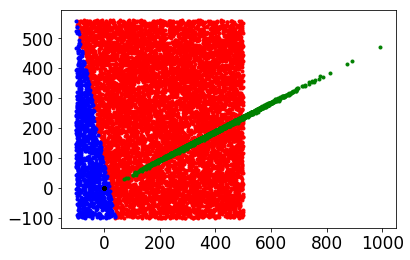

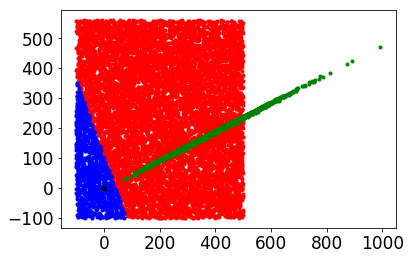

In [15]:
# 1000 epoch
plot_temp_all(feature_random, pre_label_nn,feature_t, label_t)
plot_temp_all(feature_random, pre_label_svm,feature_t, label_t)

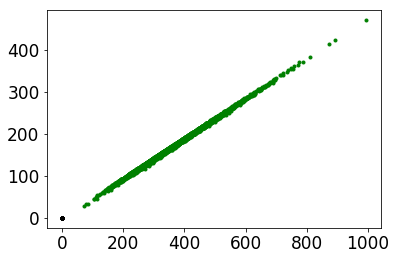

In [14]:
plot_temp(feature_t, label_t)